Initialization:

In [222]:
#Libraries
import matplotlib.pyplot as plt
import numpy as np

#World parameters
world_size = (3,3)

world_objects = {'blocked_location':{'reward': -10,'location':[1, 2, 5]},
                 'target_location':{'reward': 10,'location':[8]}}

step_reward = -1

discount_factor = 1.0
theta = 0.001


Gridmap world class

In [223]:
class Gridmap_array(object):
    def __init__(self, world_size):
        self.grid = np.zeros(world_size)
        self.vertical = world_size[1]
        self.horizontal = world_size[0]
        self.states = list(range(self.vertical*self.horizontal))
        self.actions = {'Up': -self.horizontal, 'Down': self.horizontal, 'Left': -1, 'Right': 1 } #by subtracting or adding the horizontal dimension, we can go up and down our grid space, by adding or subtracting 1 in our locations we can make horizontal movements
        self.step_reward = -1
        self.policy = self.determine_policy()

    def determine_policy(self):
        policy = {}
        for state in self.states:
            for action in self.actions:
                reward = self.step_reward
                new_state = state + self.actions[action]

                if new_state in world_objects.get('blocked_location').get('location'):
                    reward += world_objects.get('blocked_location').get('reward')
                elif new_state in world_objects.get('target_location').get('location'):
                    reward += world_objects.get('target_location').get('reward')
                elif self.validate_move(state, new_state):
                    new_state = state

                policy[(state, action)] = (new_state, reward)
        return policy
    
    def validate_move(self, current_state, new_state):
        if new_state not in self.states:
            #this prevents the actor from going off the top or the bottom of the grid
            return True
        elif current_state % self.horizontal == 0 and new_state % self.horizontal == self.horizontal -1:
            #this prevents the actor from going off the left of the grid
            return True
        elif current_state % self.horizontal == self.horizontal -1 and new_state % self.horizontal == 0:
            #this prevents the actor from going off the right of the grid
            return True
        else:
            return False
    
    def at_terminal_point(self, state):
        if state in world_objects.get('blocked_location').get('location') + world_objects.get('target_location').get('location'):
            return True

Value iteration function

In [224]:
def value_iteration(map, discount_factor, theta):
    current_values = np.zeros(np.prod(world_size))# value Function Zero for all states
    value_history = []
    value_history.append(current_values.copy())
    #print(value_history)
    #print(map.states)
    #delta = 0
    while True: #delta < theta:
        delta = 0
        for state in map.states: #iterate through the states
            if map.at_terminal_point(state):
                continue

            old_value = current_values[state]
            new_values = []

            for action in map.actions:
                (new_state, action_reward) = map.policy.get((state, action))
                #print(state, action, new_state, action_reward)
                new_values.append(action_reward + discount_factor * current_values[new_state])

            #print("new values", new_values)        
            current_values[state] = np.max(new_values)
            delta = max(delta, np.abs(old_value-current_values[state]))
        #print(current_values)
        value_history.append(current_values.copy())
        #print(value_history)
        if delta < theta:
            break
    return current_values, value_history

Code opperation

In [225]:
current_values, value_history = value_iteration(Gridmap_array(world_size),discount_factor,theta)

value_history_plot = []
for value in value_history:
    value_history_plot.append(np.sum(value))



Gridworld Value Plot

[[6. 0. 0.]
 [7. 8. 0.]
 [8. 9. 0.]]


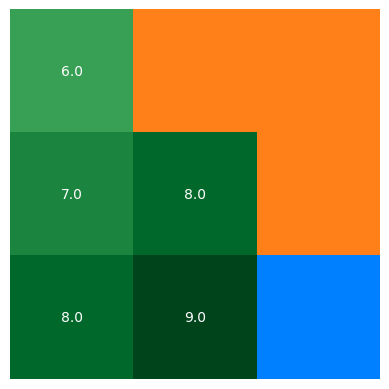

In [241]:
final_values = np.reshape(current_values, (Gridmap_array(world_size).horizontal, Gridmap_array(world_size).vertical))

cmap = plt.get_cmap('Greens', 10)
norm = plt.Normalize(final_values.min(), final_values.max())
rgba = cmap(norm(final_values))

for target in world_objects.get('target_location').get('location'):
    idx = np.unravel_index(target, final_values.shape)
    rgba[idx] = 0.0, 0.5, 1.0, 1.0

for blocked in world_objects.get('blocked_location').get('location'):
    idx = np.unravel_index(blocked, final_values.shape)
    rgba[idx] = 1.0, 0.5, 0.1, 1.0

fig, ax = plt.subplots()
im = ax.imshow(rgba, interpolation='nearest')
print(final_values)
for x in range(final_values.shape[0]):
    for y in range(final_values.shape[1]):
        if final_values[y, x] != 0:
            text = ax.text(x, y, final_values[y, x], ha="center", va="center", color="w")

plt.axis('off')
# plt.savefig('deterministic_v.jpg', bbox_inches='tight', dpi=200)
plt.show()

Value Function Plot

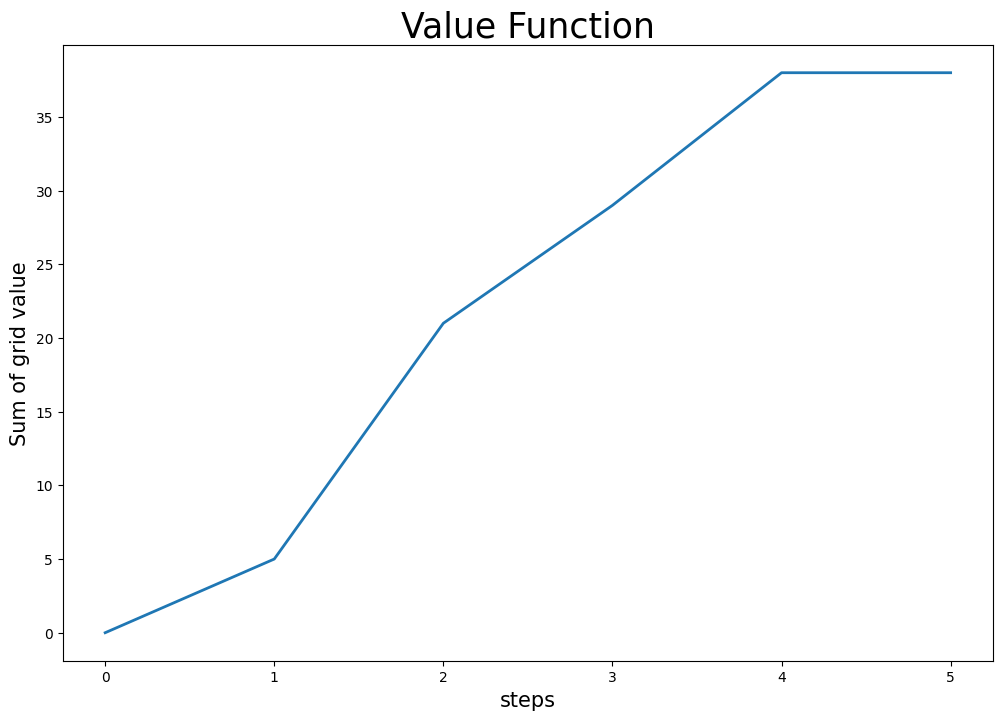

In [227]:
plt.figure(figsize=(12,8))
plt.plot(value_history_plot, linewidth=2)
plt.title('Value Function', fontsize=25)
plt.xlabel('steps', fontsize=15)
plt.ylabel('Sum of grid value', fontsize=15)
plt.grid(False)
plt.show()